# Setup

In [31]:
# Once per boot
!ipfw pipe config 1 delay 0
!ipfw pipe config 2 delay 0
!ipfw add 1 pipe 1 tcp from any 10141 to any via lo0
!ipfw add 2 pipe 2 tcp from any to any 1011 via lo0
!ifconfig lo0 mtu 1500

00001 pipe 1 tcp from any 10141 to any via lo0
00002 pipe 2 tcp from any to any dst-port 1011 via lo0


In [32]:
# Extract and build the benchmark
!rm -f ipc/ipc-static
!rm -f ipc/ipc-dynamic
!make -C ipc
!sysctl kern.ipc.maxsockbuf=33554432

cc -DWITH_PMC -Wall -o ipc-static -DPROGNAME=\"ipc-static\" ipc.c -static  -lpmc -lpthread
cc -DWITH_PMC -Wall -o ipc-dynamic -DPROGNAME=\"ipc-dynamic\" ipc.c -dynamic  -lpmc -lpthread
make: don't know how to make ipc-nonblock.c. Stop

make: stopped in /data/lab3/ipc
kern.ipc.maxsockbuf: 2097152 -> 33554432


In [2]:
import itertools
import re

def strs_to_tup(strs):
    if len(strs) == 1:
        return (strs[0].strip(),None)
    else:
        return (strs[0].strip(),strs[1].strip())

def flatten(lst):
    return list(itertools.chain.from_iterable(lst))

def parse(cmd_out):
    tups = map(strs_to_tup, [string.split(":") for string in cmd_out])
    return dict(tups)

def genfilename(exe, mode, ipc, runs, flags, suffix="", extension = "png"):
    return "{}_{}_{}_runs_{}_{}{}.{}".format(re.sub(r'[/-]', r'_', exe), mode, ipc, runs, re.sub(r'\s*-', r'', flags), suffix, extension)

def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

In [3]:
import time
from __future__ import print_function
from decimal import Decimal
import pandas as pd
import numpy as np
%matplotlib inline
# import matplotlib.pyplot as plt
#import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
from cStringIO import StringIO
import sys

def label_points(x, y, ax):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], "{:.2E}".format(Decimal(point['x'])))

def graph(xs, ys, num_trials = 0, save = False, save_name = None, texty = 100, ylog = False, xlog = False, title = None, xlabel = None, ylabel = None, label = '_nolegend_', axis = None):
    # plt.style.use('seaborn-whitegrid')
    xvalues = np.reshape(ys, (len(xs), num_trials))[:,:]
    #xvalues = np.reshape(ys, (len(xs)/num_trials, num_trials))[:,:]
    df = pd.DataFrame(xvalues, index=xs)
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]
    if axis is not None:
        ax = df.median(1).plot(yerr=error_bars_values, title=title, ax=axis, label = label)
    else:
        fig = plt.figure(figsize=(18,6))
        ax = df.median(1).plot(yerr=error_bars_values, title=title, label = label)

    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if label:
        ax.set_label(label)
    if title:
        ax.set_title(title)
    if ylog:
        ax.set_yscale('log')
    if xlog:
        ax.set_xscale('log')
    ax.set_xticks(df.index)
    ax.set_xticklabels(xs, rotation=45)
    plt.grid('on', axis='x' )
    plt.grid('on', axis='y' )
    plt.legend()
    if save_name is not None:
        ax.get_figure().savefig("{}".format(save_name))
    return ax

def benchmark(flags, repeat, exe, mode, ipc, buf_sizes, tot_sizes, default_buffer = False, dtrace_info = None, bench_name = "", pmc = None, quiet = False, purge_cache = False):
    runs = range(1, repeat + 1)
    outputs = []
    if not quiet:
        print("\t ==> Running {}".format(exe))
        print("\t\t ==> {} across {}".format(ipc, mode))
    is_dtrace = (dtrace_info != None)
    if is_dtrace and not quiet:
        print("\t\t ==> Running in DTrace mode")
    dtrace_thread = None
    verbose = "-v" in flags
    qmode = "-q" in flags
    pmc_enabled = pmc is not None
    dtrace_quite_mode = dtrace_info['quiet'] if 'quiet' in dtrace_info else False

    for buffer_size in buf_sizes:
        for tot_size in tot_sizes:
            if default_buffer:
                cmd = "{} {} -i {} {}".format(exe, flags, ipc, mode)
            else:
                cmd = "{} {} -i {} -b {} -t {} {}".format(exe, flags, ipc, buffer_size, tot_size, mode)

            discard = !{cmd} # Discard first benchmark run which may be biased
            if is_dtrace:
                dtraceSleep = dtrace_info['sleep'] if 'sleep' in dtrace_info else 1
                walkFunc = dtrace_info['agg_fn'] if 'agg_fn' in dtrace_info else None
                outFn = dtrace_info['out_fn'] if 'out_fn' in dtrace_info else None
                # Create a seperate thread to run the DTrace instrumentation
                if dtrace_quite_mode:
                    old_stdout = sys.stdout
                    sys.stdout = mystdout = StringIO()
                dtrace_thread = DTraceConsumerThread(dtrace_info['script'],
                                                        chew_func=lambda v: None,
                                                        chewrec_func=lambda v: None,
                                                        walk_func=None,
                                                        out_func=outFn,
                                                        sleep=dtraceSleep)
                # Start the DTrace instrumentation
                dtrace_thread.start()

            results = []
            for i in runs:
                out = !{cmd}
                if purge_cache:
                    purge_cmd = "sysctl net.inet.tcp.hostcache.purgenow=1"
                    !{purge_cmd}
                parsed = parse(out)
                results.append(parsed)

            if is_dtrace and dtrace_thread != None:
                # The benchmark has completed - stop the DTrace instrumentation
                dtrace_thread.stop()
                dtrace_thread.join()
                dtrace_thread.consumer.__del__() # Memory leak workaround

            times = [float(item['time']) for item in results] if verbose else None
            avg_time = sum(times) / len(runs) if verbose else None

            if not qmode:
                speeds = [float(item['speed'].split(' ')[0]) for item in results] # Need to split by ' ' because output speed has units attached to it (see ipc.c)
            else:
                speeds = []
            avg_speed = sum(speeds) / len(runs)
            if not quiet:
                print("\t\t\t{0:2} bytes {1:2} bytes: {2:.2f} KBytes/sec".format(buffer_size, tot_size, avg_speed))
            res = {'buffersize':buffer_size, 'time':avg_time, 'speed':avg_speed, 'tot_sz':tot_size, 'speeds': speeds, 'times': times}
            if pmc_enabled:
                pmc_data = gather_pmc_vals({}, results, pmc)

                avgs = {}
                for key,val in pmc_data.iteritems():
                    avg_key = "avg_" + key
                    avgs[avg_key] = sum(val) / len(runs)

                pmc_data['pmctype'] = results[0]["pmctype"]
                # Merge dictionaries
                pmc_data = merge_two_dicts(avgs, pmc_data)
                res = merge_two_dicts(res, pmc_data)
            outputs.append(res)
            if dtrace_quite_mode:
                sys.stdout = old_stdout
    return outputs

def highlight(axis, texty = 100):
    axis.axvspan(0, 8192, alpha=0.15, color='r')
    axis.axvspan(8193, 32768, alpha=0.15, color='g')
    axis.axvspan(32769, 65536, alpha=0.15, color='m')
    axis.axvspan(65537, 131072, alpha=0.15, color='c')
    axis.axvspan(131073, 262144, alpha=0.15, color='y')
    axis.text(3500, texty, "4K Page Size")
    axis.text(12000, texty, "16K PIPE_SIZE")
    axis.text(30000, texty, "32K L1")
    axis.text(90000, texty, "32x4K TLB entries")
    axis.text(250000, texty, "256K L2")

In [4]:
D_transitions_snd2rcv = """
fbt::tcp_state_change:entry
/args[0]->t_inpcb->inp_inc.inc_ie.ie_lport == htons(10141)/
{
    printf("{\\"timestamp\\": %u, \\"local_port\\": %u, \\"foreign_port\\": %u, \\"previous_tcp_state\\": \\"%s\\", \\"tcp_state\\": \\"%s\\"}", 
    walltimestamp,
    ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport),
    ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport),
    tcp_state_string[args[0]->t_state],
    tcp_state_string[args[1]]);

    stack();
}
"""

D_transitions_rcv2snd = """
fbt::tcp_state_change:entry
/args[0]->t_inpcb->inp_inc.inc_ie.ie_fport == htons(10141)/
{
    printf("{\\"timestamp\\": %u, \\"local_port\\": %u, \\"foreign_port\\": %u, \\"previous_tcp_state\\": \\"%s\\", \\"tcp_state\\": \\"%s\\"}", 
    walltimestamp,
    ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport),
    ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport),
    tcp_state_string[args[0]->t_state],
    tcp_state_string[args[1]]);

    stack();
}
"""

# For probe effect
D_rcv_tcp_in = """
/* From receiver to sender */
fbt::tcp_do_segment:entry
/args[1]->th_dport == htons(10141)
    || args[1]->th_sport == htons(10141)/
{
        ((unsigned int)args[1]->th_seq);
        ((unsigned int)args[1]->th_ack);
        (args[3]->t_state);
}

"""

D_snd_tcp_in = """
/* From sender to receiver */
#pragma D option bufsize=3M
#pragma D option bufresize=manual

fbt::tcp_do_segment:entry
/args[1]->th_sport == htons(10141)/
{
        /*trace((unsigned int)args[1]->th_seq);
        trace((unsigned int)args[1]->th_ack);*/
        trace(tcp_state_string[args[3]->t_state]);
        printf("[%s", (args[1])->th_flags & TH_FIN ? "FIN|" : "");
        printf("%s", (args[1])->th_flags & TH_SYN ? "SYN|" : "");
        printf("%s", (args[1])->th_flags & TH_RST ? "RST|" : "");
        printf("%s", (args[1])->th_flags & TH_PUSH ? "PUSH|" : "");
        printf("%s", (args[1])->th_flags & TH_ACK ? "ACK|" : "");
        printf("%s", (args[1])->th_flags & TH_URG ? "URG|" : "");
        printf("%s", (args[1])->th_flags & TH_ECE ? "ECE|" : "");
        printf("%s]", (args[1])->th_flags & TH_CWR ? "CWR" : "");
}
"""

D_state_change = """
fbt::tcp_state_change:entry
/args[0]->t_inpcb->inp_inc.inc_ie.ie_lport == htons(10141)
        || args[0]->t_inpcb->inp_inc.inc_ie.ie_fport == htons(10141)/
{
        printf("{ \\"time\\":\\"%u\\", \\"local_port\\":\\"%u\\", \\"foreign_port\\":\\"%u\\", \\"previous_tcp_state\\":\\"%s\\", \\"tcp_state\\":\\"%s\\" }",
        walltimestamp,
        ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport),
        ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport),
        tcp_state_string[args[0]->t_state],
        tcp_state_string[args[1]]);

        stack();
}
/*
fbt::syncache_add:entry
/args[3]->inp_inc.inc_ie.ie_lport == htons(10141)
        || args[3]->inp_inc.inc_ie.ie_fport == htons(10141)/
{
        printf("{ \\"probefunc\\":\\"%s\\", \\"local_port\\":\\"%u\\", \\"foreign_port\\":\\"%u\\", \\"flags\\":\\"%d\\" }",
        probefunc,
        ntohs(args[3]->inp_inc.inc_ie.ie_lport),
        ntohs(args[3]->inp_inc.inc_ie.ie_fport),
        (args[2])->th_flags);

        stack();
}

fbt::syncache_expand:entry
/args[0]->inc_ie.ie_lport == htons(10141)
        || args[0]->inc_ie.ie_fport == htons(10141)/
{
        printf("{ \\"probefunc\\":\\"%s\\", \\"local_port\\":\\"%u\\", \\"foreign_port\\":\\"%u\\", \\"flags\\":\\"%d\\" }",
        probefunc,
        ntohs(args[0]->inc_ie.ie_lport),
        ntohs(args[0]->inc_ie.ie_fport),
        (args[2])->th_flags);

        stack();
}
*/
"""

In [5]:
import pygraphviz as pgv
from IPython.display import Image

# TCP related utils
def print_ascii_state_machine(out):
    for key,elem in out.iteritems():
        for raw_value in elem:
            try:
                value = json.loads(raw_value)
                # JSON formatted string
                if value['previous_tcp_state'] is not None and value['tcp_state'] is not None:
                    print("State transition {} ({}) -> {} ({})".format(value['previous_tcp_state'],
                                                                       value['local_port'], value['tcp_state'],
                                                                       value['foreign_port']))
                else:
                    print("String malformatted missing previous_tcp_state of tcp_state fields")
            except ValueError as e:
                # Raw string - manually post-process
                print("Preceeding stack frame {}".format(raw_value.split('\n')[1]))
        print("\n")

def draw_state_machine(data, latency):
    # Create state machine
    g = pgv.AGraph(
        label="TCP state machine ({} ms)".format(latency), strict=False, directed=True)

    # Add edges
    edges_to_add = []
    for raw_value in data[latency]:
        arch = ""
        try:
            value = json.loads(raw_value)
            if 'local_port' in value:
                arch = "server" if value['local_port'] == '10141' else "client"
            # JSON formatted string
            if 'probefunc' in value:
                print(value['probefunc'])
                edges_to_add.append(value['probefunc'])
                edges_to_add.append(value['probefunc'])
                edges_to_add.append(arch)
            elif value['previous_tcp_state'] is not None and value['tcp_state'] is not None:
                edges_to_add.append(value['previous_tcp_state'])
                edges_to_add.append(value['tcp_state'])
                edges_to_add.append(arch)
            else:
                print("String malformatted missing previous_tcp_state of tcp_state fields")
        except ValueError as e:
            # Raw string - manually post-process
            # print("Preceeding stack frame {}".format(raw_value.split('\n')[1]))
            syscall = raw_value.split('\n')[1].split('`')[1].split('+')[0]
            label = "{}: {}".format(edges_to_add[2], syscall)
            g.add_edge(edges_to_add[0], edges_to_add[1], label=label, color='green')
            edges_to_add = []

    closed_node = g.get_node("state-closed")
    closed_node.attr['shape']='box'
    closed_node.attr['color']='blue'

    # Draw the state machine
    return g

In [6]:
def process_segments(filename, extra = [], port = "source"):
    ENTRIES = []
    attrs = ["Time", "Seq", "Ack"] + extra
    text_file = open(filename, "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split() for l in lines if "tcp_do_segment" in l]

    # Aggregate info into list
    # Order is important
    for e in lines:
        entry = {}
        for kv in e:
            split = kv.split(':')
            if len(split) == 2:
                entry[split[0]] = split[1]
        ENTRIES.append(entry);

    ret = {}
    for a in attrs:
        ret[a] = []
    for e in ENTRIES:
        if int(e[port]) == 10141:
            for a in attrs:
                #if a == "Time":
                #    ret[a].append(float(e[a]) / 1000000000)
                #else:
                #    ret[a].append(int(e[a]))
                ret[a].append(int(e[a]))
    return ret

In [27]:
def time_bw_data(filename, time_diffs = 0.001):
    TIMES = []
    ENTRIES = []
    text_file = open("{}.log".format(filename), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split() for l in lines if "tcp_do_segment" in l]

    # Aggregate info into list
    # Order is important
    for e in lines:
        entry = {}
        if e == '#':
            ENTRIES.append(e)
        for kv in e:
            split = kv.split(':')
            if len(split) == 2:
                entry[split[0]] = split[1]
        ENTRIES.append(entry)

    final_len = 0
    TIME_SPLIT = 150
    cur_time = float(ENTRIES[0]["Time"])
    cur_seq = float(ENTRIES[0]["Seq"])
    bws = []
    unit_ctr = 0
    for e in ENTRIES:
        diff = ((float(e["Time"]) - cur_time) / 1000000000)
        if diff > time_diffs and int(e["source"]) == 10141:
            bws.append(e)
            cur_time = float(e["Time"])

    bws = zip(bws[::2], bws[1::2])

    # TODO: make sure sequence numbers are sorted in "bws"
    tps = []
    for e in bws:
        tp = (float(e[1]["Seq"]) - float(e[0]["Seq"])) / (float(e[1]["Time"]) - float(e[0]["Time"]))
        tps.append(max(tp, 0))

    times = [list(b)[1]["Time"] for b in bws]
    times = [(float(t) - float(times[0]))/1000000000 for t in times]
    return (times, tps)

In [8]:
def calc_bw(data):
    sortedKeys = data.keys()
    sortedKeys.sort()
    for buf in sortedKeys:
        ns = float(data[buf]['vtime']) / float(1e9)
        print(str((buf / 1024) / ns) + " KB/sec.")

# Callbacks invoked to process the aggregation
def test_agg(a, b, c, d):
    print("From DTrace: {} | {} | {} | val: {}".format(a,b,c,d))
def test_out(val):
    print("From DTrace: val: {}".format(val))

def simple_agg(a, b, c, d):
    values.append(d)
def simple_out(val):
    values.append(val)

def acc_agg(a, b, c, d):
    if c[0] not in values:
        values[c[0]] = [d]
    else:
        values[c[0]].append(d)

def map_agg(a, b, c, d):
    if len(c):
        values[c[0]] = d

def pair_agg(a, b, c, d):
    values.append((c, d))

def quantized_agg(a, b, c, d):
    dist = d
    filtered = [tup if tup[0][0] >= -2 and tup[0][0] <= BUFFER_SIZES[-1] else None for tup in dist]
    filtered = [x for x in filtered if x is not None ]
    values[c[0]] = filtered

def dummy_agg(a, b, c, d):
    pass

print("Set up completed")

Set up completed


# State Machine

In [55]:
# States from state_change
# Headers from tcp_do_segment
# Syscalls from state_change stack (if headers not available)

MODE="2thread"
IPC="tcp"
FLAGS="-B -q"
RUNS=1
DRUNS=1
EXE = "ipc/ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
TOT_SIZES=[BUFFER_SIZES[-1]]
BUF_SIZE=[131072]
LATENCIES=range(0, 45, 5) # 0-40ms

out = {}
values = []
for lat in LATENCIES:
    print("Latency: {}".format(lat))
    # Run benchmark with DTrace
    !ipfw pipe config 1 delay {str(lat)}
    !ipfw pipe config 2 delay {str(lat)}
    benchmark(FLAGS, 1, EXE, MODE, IPC, BUF_SIZE, TOT_SIZES, default_buffer = True, dtrace_info = {'out_fn':simple_out, 'script':D_state_change},
                 purge_cache = False)
    time.sleep(1)
    out[lat] = values
    values = []
    print("Finished with latency")
pd.to_pickle(out, "pkls/state_changes.pkl")

Latency: 0
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 0.00 KBytes/sec
Finished with latency
Latency: 15
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 0.00 KBytes/sec
Finished with latency
Latency: 30
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 0.00 KBytes/sec
Finished with latency
Latency: 45
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 0.00 KBytes/sec
Finished with latency
Latency: 60
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 0.00 KBytes/sec
Finished with latency
Latency: 75
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 0.00 KBytes/sec
Finished with latency

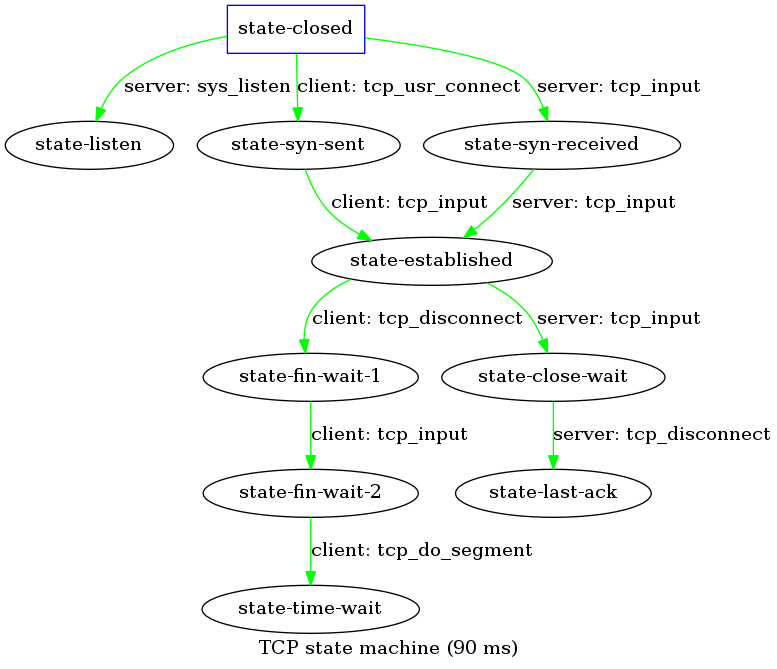

In [56]:
out = pd.read_pickle("pkls/state_changes.pkl")

g = draw_state_machine(out, 90)
Image(g.draw(format='png', prog='dot'))

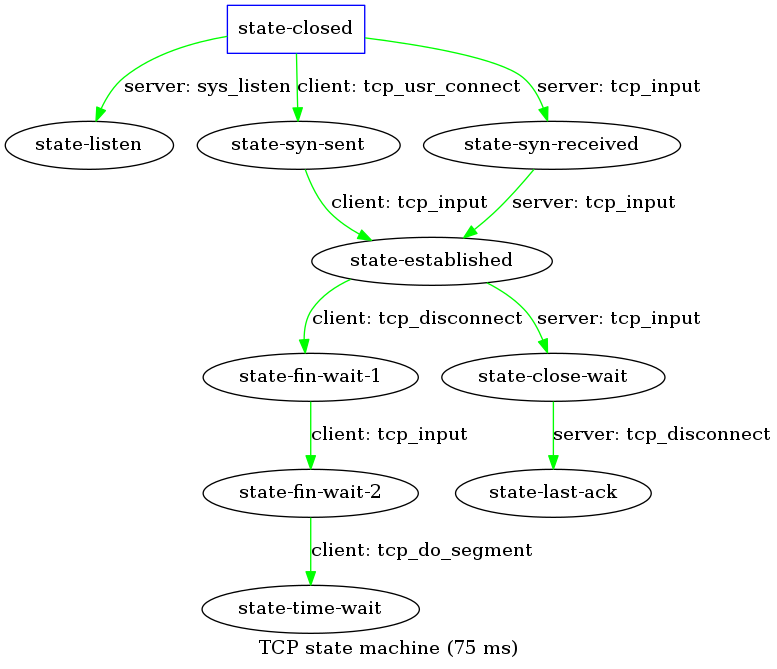

In [58]:
g = draw_state_machine(out, 75)
Image(g.draw(format='png', prog='dot'))

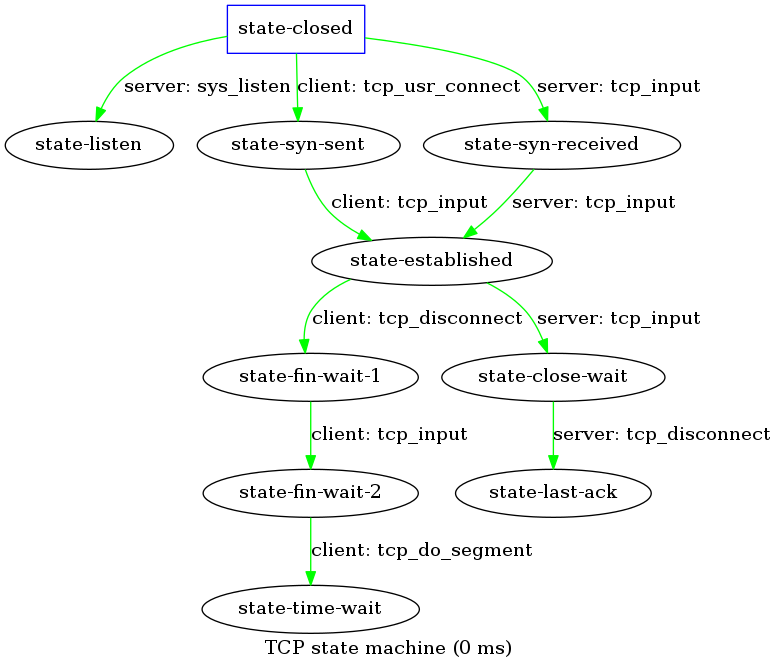

In [59]:
g = draw_state_machine(out, 0)
Image(g.draw(format='png', prog='dot'))

#  Bandwidth vs. Latency

# Purge Cache Performance

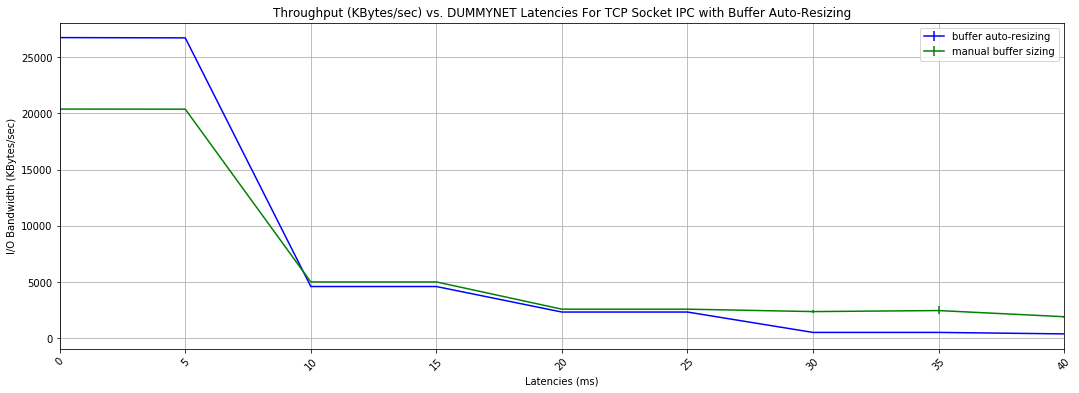

In [39]:
MODE="2thread"
IPC="tcp"
RUNS=12
EXE = "ipc/ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
TOT_SIZES=[BUFFER_SIZES[-1]]
BUF_SIZE=[1048576]
LATENCIES=range(0, 45, 5) # 0-40ms

#ret = []
#FLAGS=""
#for lat in LATENCIES:
#    # Run benchmark with DTrace
#    !ipfw pipe config 1 delay {str(lat)}
#    !ipfw pipe config 2 delay {str(lat)}
#    ret.append(benchmark(FLAGS, 12, EXE, MODE, IPC, BUF_SIZE, TOT_SIZES, purge_cache = True)[0])
#pd.to_pickle(ret, "pkls/latency_vs_bandwidth_purge.pkl")

ret = pd.read_pickle("pkls/latency_vs_bandwidth_purge.pkl")
p = graph(LATENCIES, flatten([item['speeds'] for item in ret]), RUNS,
         xlabel='Latencies (ms)', ylabel='I/O Bandwidth (KBytes/sec)',
          label="buffer auto-resizing", title = "Throughput (KBytes/sec) vs. DUMMYNET Latencies For TCP Socket IPC with Buffer Auto-Resizing")

#ret = []
#FLAGS="-s"
#for lat in LATENCIES:
#    # Run benchmark with DTrace
#    !ipfw pipe config 1 delay {str(lat)}
#    !ipfw pipe config 2 delay {str(lat)}
#    ret.append(benchmark(FLAGS, 12, EXE, MODE, IPC, BUF_SIZE, TOT_SIZES, purge_cache = True)[0])
#pd.to_pickle(ret, "pkls/latency_vs_bandwidth_match_purge.pkl")

saveas = "latency_vs_bw_all"
ret = pd.read_pickle("pkls/latency_vs_bandwidth_match_purge.pkl")
graph(LATENCIES, flatten([item['speeds'] for item in ret]), RUNS,
      axis = p, label="manual buffer sizing", save = True, save_name = saveas)

# Time vs. Bandwidth

## Average

In [63]:
RUNS = 8
LATENCY = 40 # 20ms RTT
BWS = []
TIMES = []
for i in range(1, RUNS + 1):
    FILENAME = "combined_{}_{}".format(LATENCY, i)
    (ts, bs) = time_bw_data(FILENAME)
    BWS.append(bs)
    TIMES.append(ts)

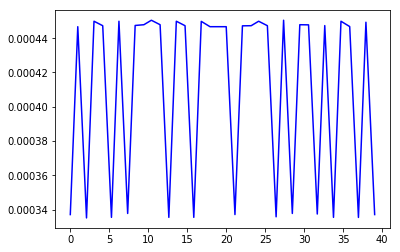

In [64]:
min_length = len(BWS[0])
for b in BWS:
    min_length = min(min_length, len(b))
NEW_BWS = []
NEW_TIMES = []
for b in BWS:
    NEW_BWS.append(b[:min_length])
for t in TIMES:
    NEW_TIMES.append(t[:min_length])
TIMES = NEW_TIMES
BWS = NEW_BWS

AVGS = [sum(list(b)) / len(b) for b in zip(*BWS)]
plt.plot(TIMES[0], AVGS)

#graph(TIMES[0], AVGS, 1, label = "RTT = 10ms")

## Single Run

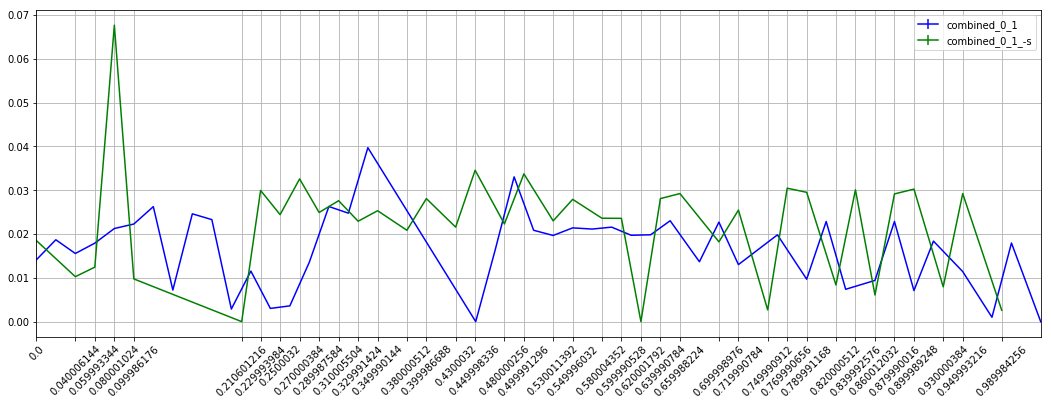

In [35]:
RUNS = 8
FLAGS = ""
EXE = "ipc-static"

FILENAME="combined_0_1"
(t1, b1) = time_bw_data(FILENAME)
p = graph(t1, b1, 1, label=FILENAME)

FILENAME="combined_0_1_-s"
(t2, b2) = time_bw_data(FILENAME, time_diffs = 0.001)
p = graph(t2, b2, 1, label=FILENAME, axis = p)

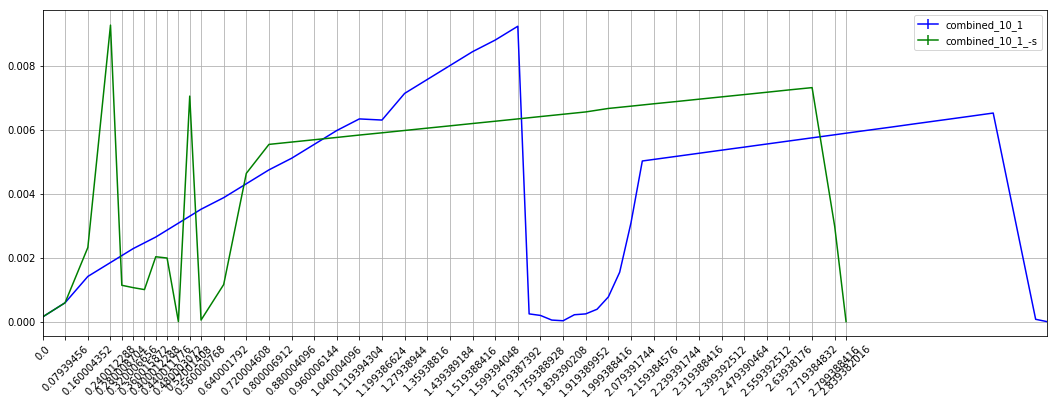

In [32]:
RUNS = 8
FLAGS = ""
EXE = "ipc-static"

FILENAME="combined_10_1"
(t1, b1) = time_bw_data(FILENAME)
p = graph(t1, b1, 1, label=FILENAME)

FILENAME="combined_10_1_-s"
(t2, b2) = time_bw_data(FILENAME, time_diffs = 0.001)
p = graph(t2, b2, 1, label=FILENAME, axis = p)

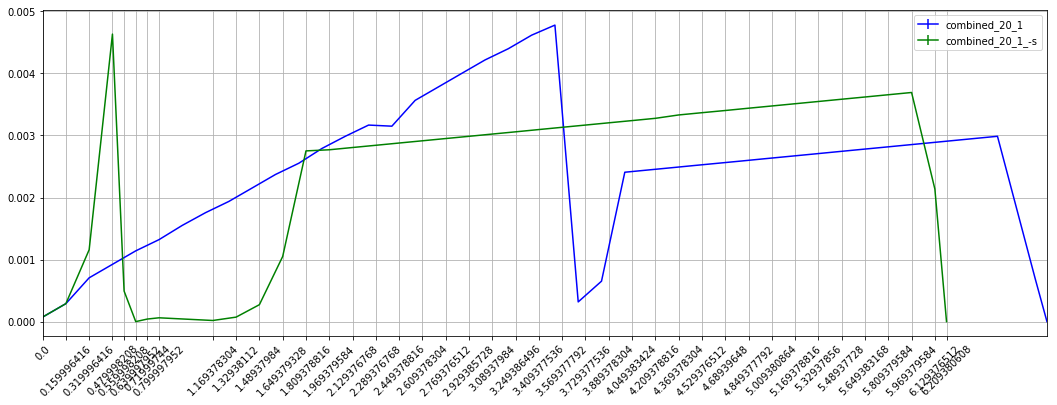

In [33]:
FILENAME="combined_20_1"
(t1, b1) = time_bw_data(FILENAME)
p = graph(t1, b1, 1, label=FILENAME)

FILENAME="combined_20_1_-s"
(t2, b2) = time_bw_data(FILENAME, time_diffs = 0.001)
p = graph(t2, b2, 1, label=FILENAME, axis = p)

## 20ms

In [37]:
ret_rcv = process_segments("combined_20_1.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd = process_segments("combined_20_1.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks, acks, wnd = (ret_rcv["Time"], ret_rcv["Ack"], ret_rcv["wnd"])
times_seqs, seqs = (ret_snd["Time"], ret_snd["Seq"])

In [38]:
ret_rcv_s = process_segments("combined_20_1_-s.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd_s = process_segments("combined_20_1_-s.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks_s, acks_s, wnd_s = (ret_rcv_s["Time"], ret_rcv_s["Ack"], ret_rcv_s["wnd"])
times_seqs_s, seqs_s = (ret_snd_s["Time"], ret_snd_s["Seq"])

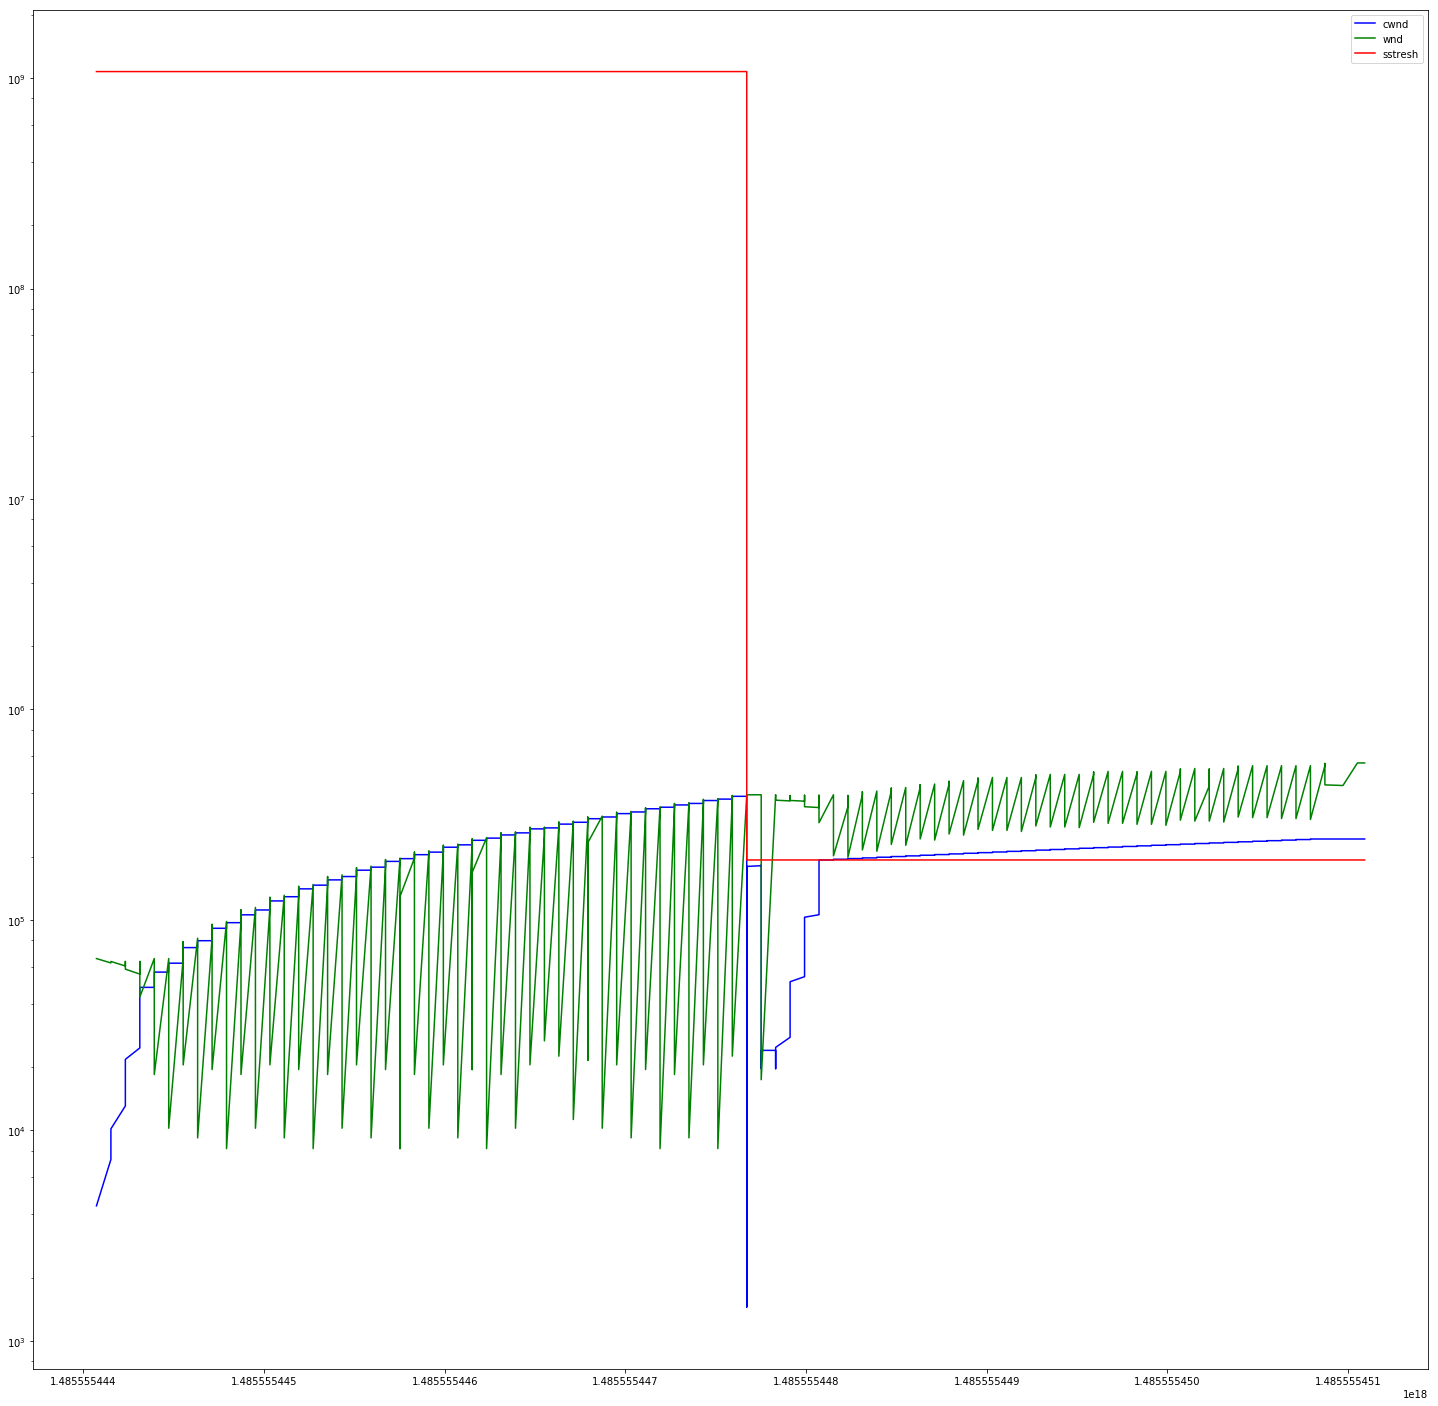

In [41]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
wnd, cwnd, ssthresh = (ret_rcv["wnd"], ret_rcv["cwnd"], ret_rcv["ssthresh"])
ax.plot(times_acks, cwnd, label = "cwnd")
ax.plot(times_acks, wnd, label = "wnd")
ax.plot(times_acks, ssthresh, label = "sstresh")
ax.set_yscale('log')
ax.legend()

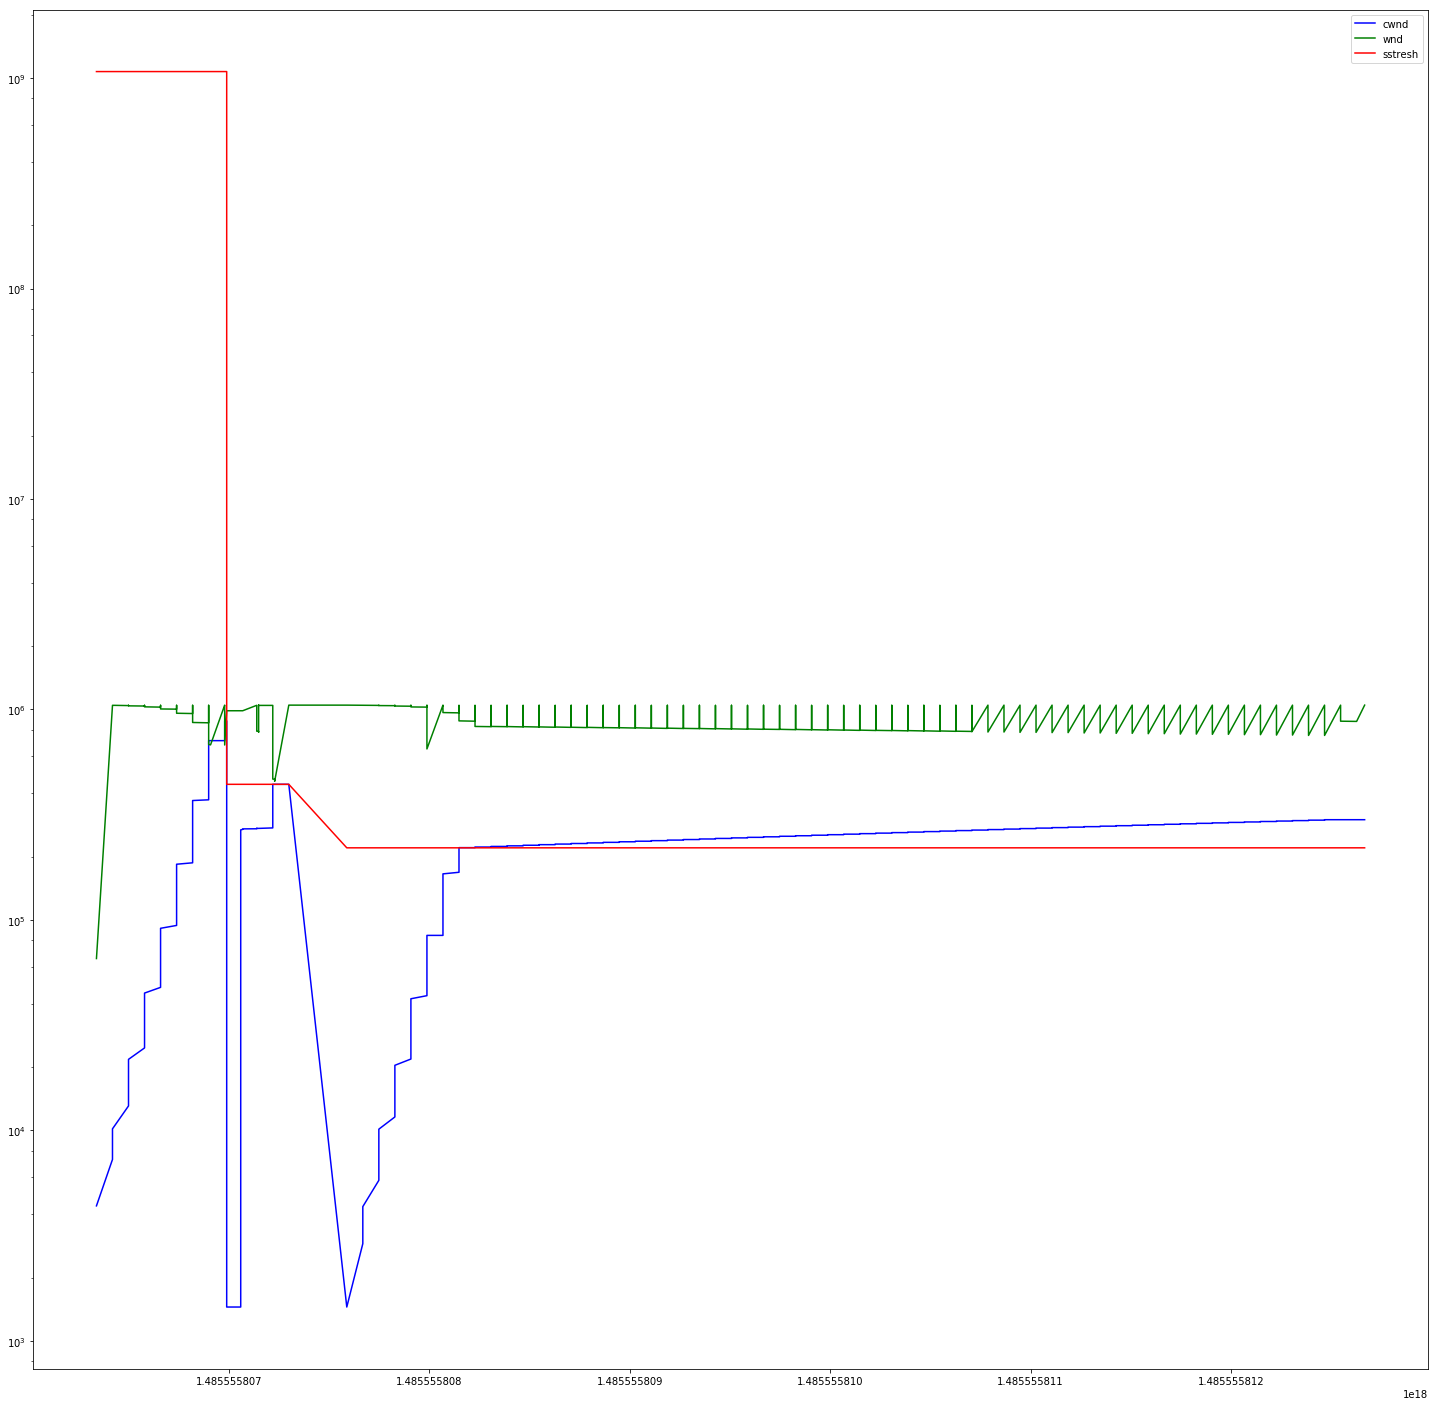

In [40]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
wnd_s, cwnd_s, ssthresh_s = (ret_rcv_s["wnd"], ret_rcv_s["cwnd"], ret_rcv_s["ssthresh"])
ax.plot(times_acks_s, cwnd_s, label = "cwnd")
ax.plot(times_acks_s, wnd_s, label = "wnd")
ax.plot(times_acks_s, ssthresh_s, label = "sstresh")
ax.set_yscale('log')
ax.legend()

## 0ms

In [42]:
ret_rcv = process_segments("combined_0_1.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd = process_segments("combined_0_1.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks, acks, wnd = (ret_rcv["Time"], ret_rcv["Ack"], ret_rcv["wnd"])
times_seqs, seqs = (ret_snd["Time"], ret_snd["Seq"])
ret_rcv_s = process_segments("combined_0_1_-s.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd_s = process_segments("combined_0_1_-s.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks_s, acks_s, wnd_s = (ret_rcv_s["Time"], ret_rcv_s["Ack"], ret_rcv_s["wnd"])
times_seqs_s, seqs_s = (ret_snd_s["Time"], ret_snd_s["Seq"])

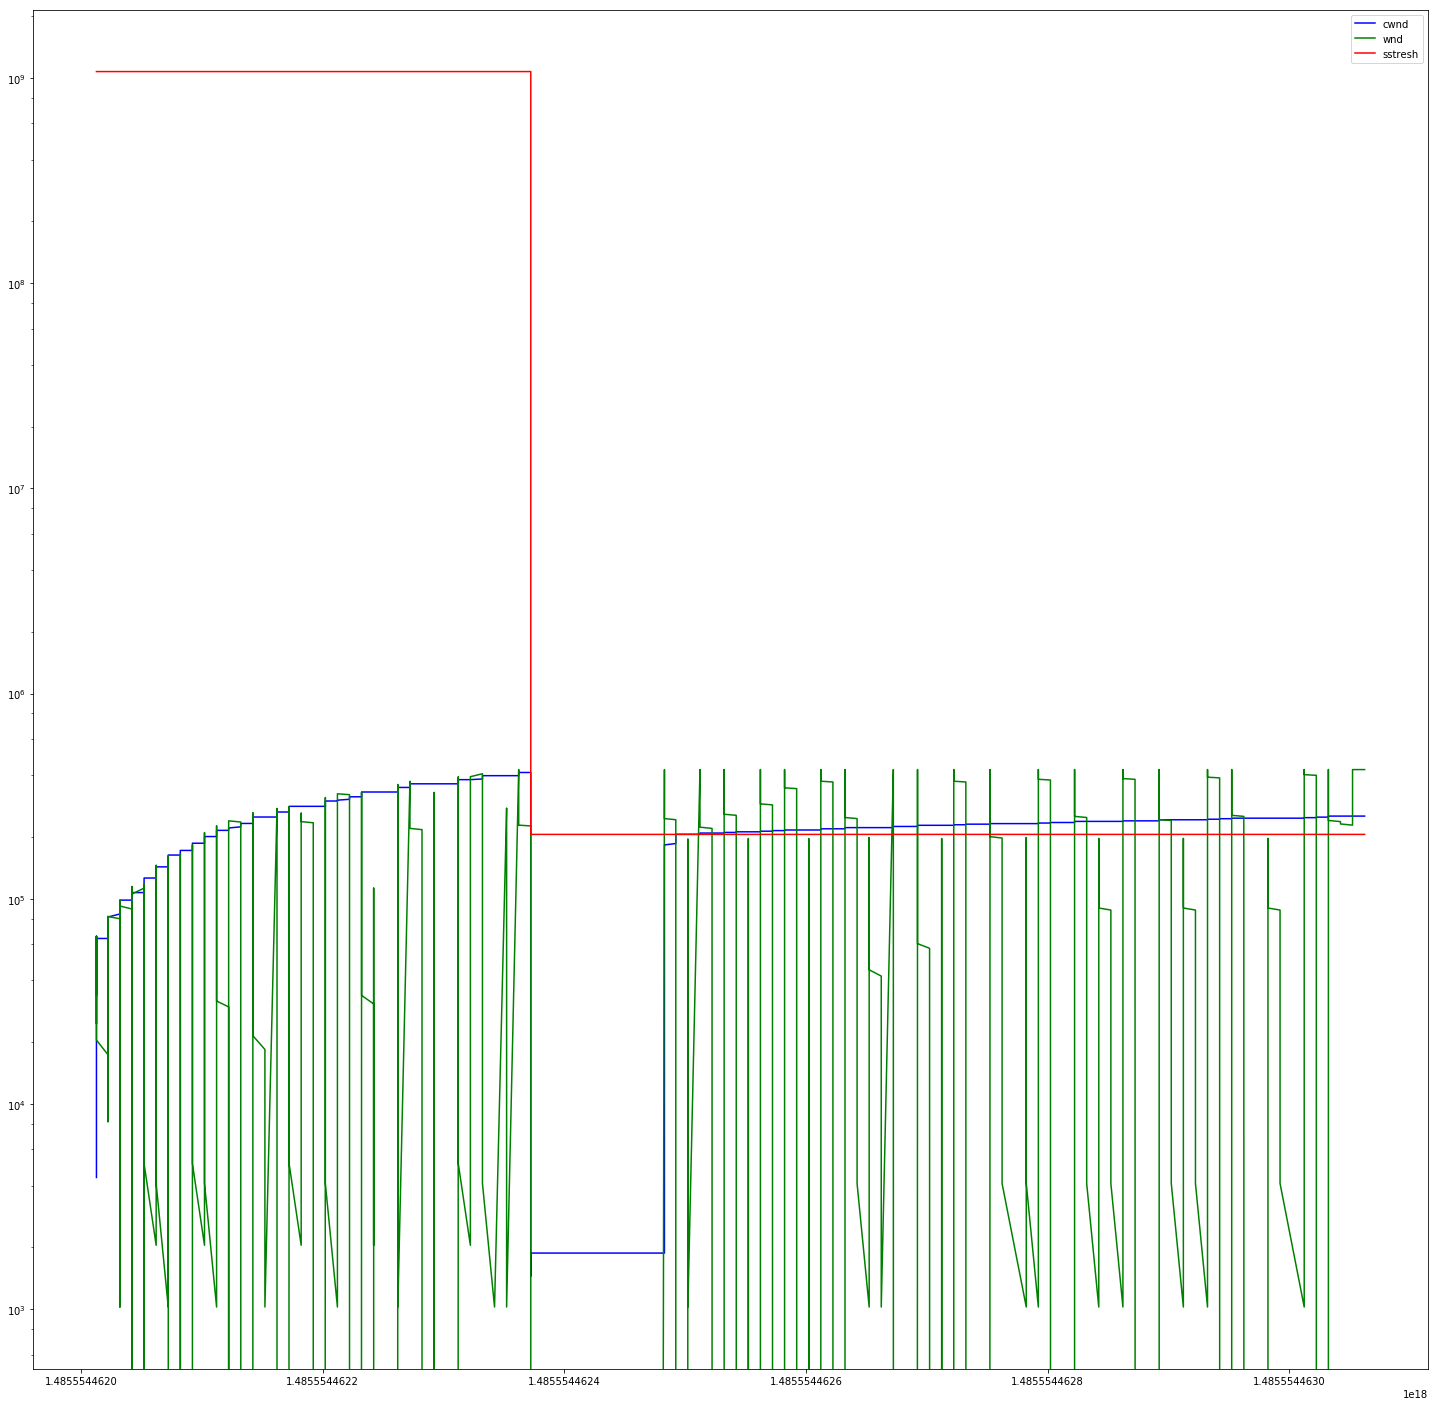

In [44]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
wnd, cwnd, ssthresh = (ret_rcv["wnd"], ret_rcv["cwnd"], ret_rcv["ssthresh"])
ax.plot(times_acks, cwnd, label = "cwnd")
ax.plot(times_acks, wnd, label = "wnd")
ax.plot(times_acks, ssthresh, label = "sstresh")
ax.set_yscale('log')
ax.legend()

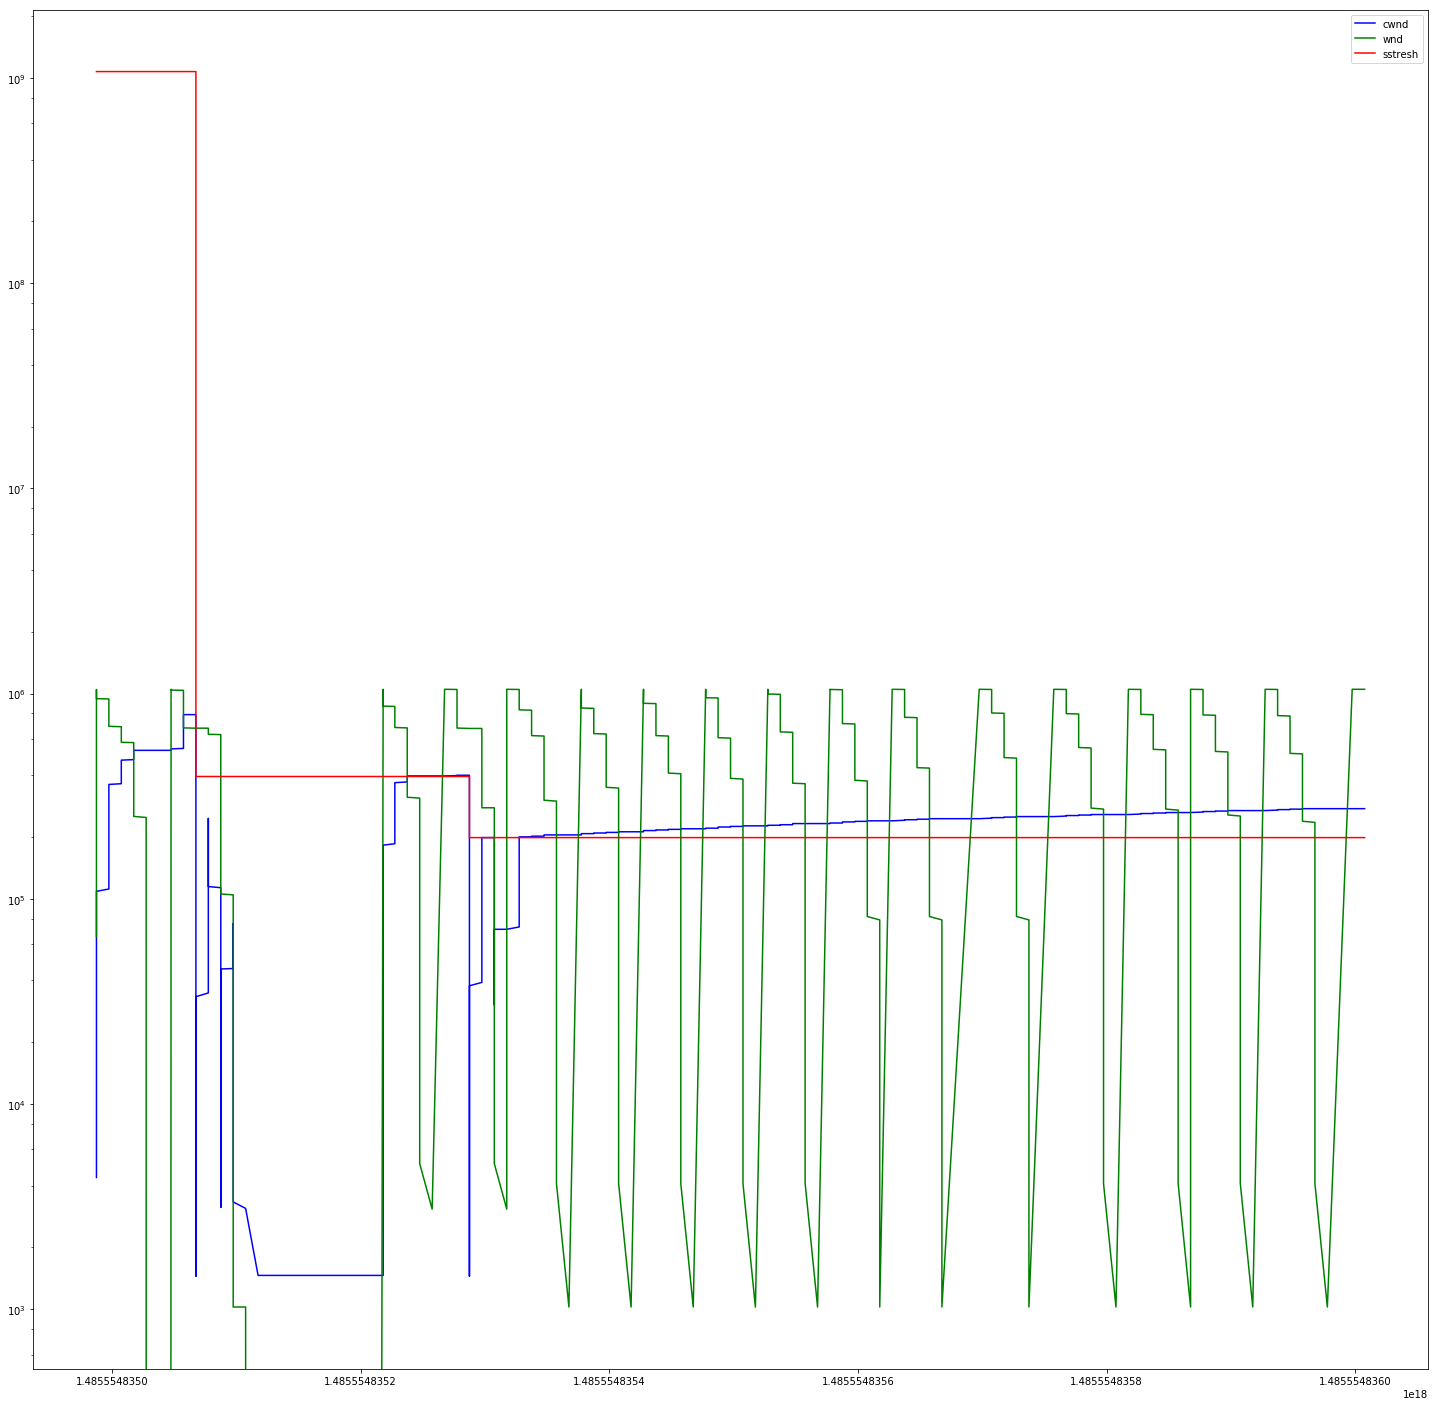

In [45]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
wnd_s, cwnd_s, ssthresh_s = (ret_rcv_s["wnd"], ret_rcv_s["cwnd"], ret_rcv_s["ssthresh"])
ax.plot(times_acks_s, cwnd_s, label = "cwnd")
ax.plot(times_acks_s, wnd_s, label = "wnd")
ax.plot(times_acks_s, ssthresh_s, label = "sstresh")
ax.set_yscale('log')
ax.legend()

# Seq-Time Diagrams

## 20ms RTT

In [48]:
ret_rcv = process_segments("combined_10_1.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd = process_segments("combined_10_1.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks, acks, wnd = (ret_rcv["Time"], ret_rcv["Ack"], ret_rcv["wnd"])
times_seqs, seqs = (ret_snd["Time"], ret_snd["Seq"])
ret_rcv_s = process_segments("combined_10_1_-s.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd_s = process_segments("combined_10_1_-s.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks_s, acks_s, wnd_s = (ret_rcv_s["Time"], ret_rcv_s["Ack"], ret_rcv_s["wnd"])
times_seqs_s, seqs_s = (ret_snd_s["Time"], ret_snd_s["Seq"])

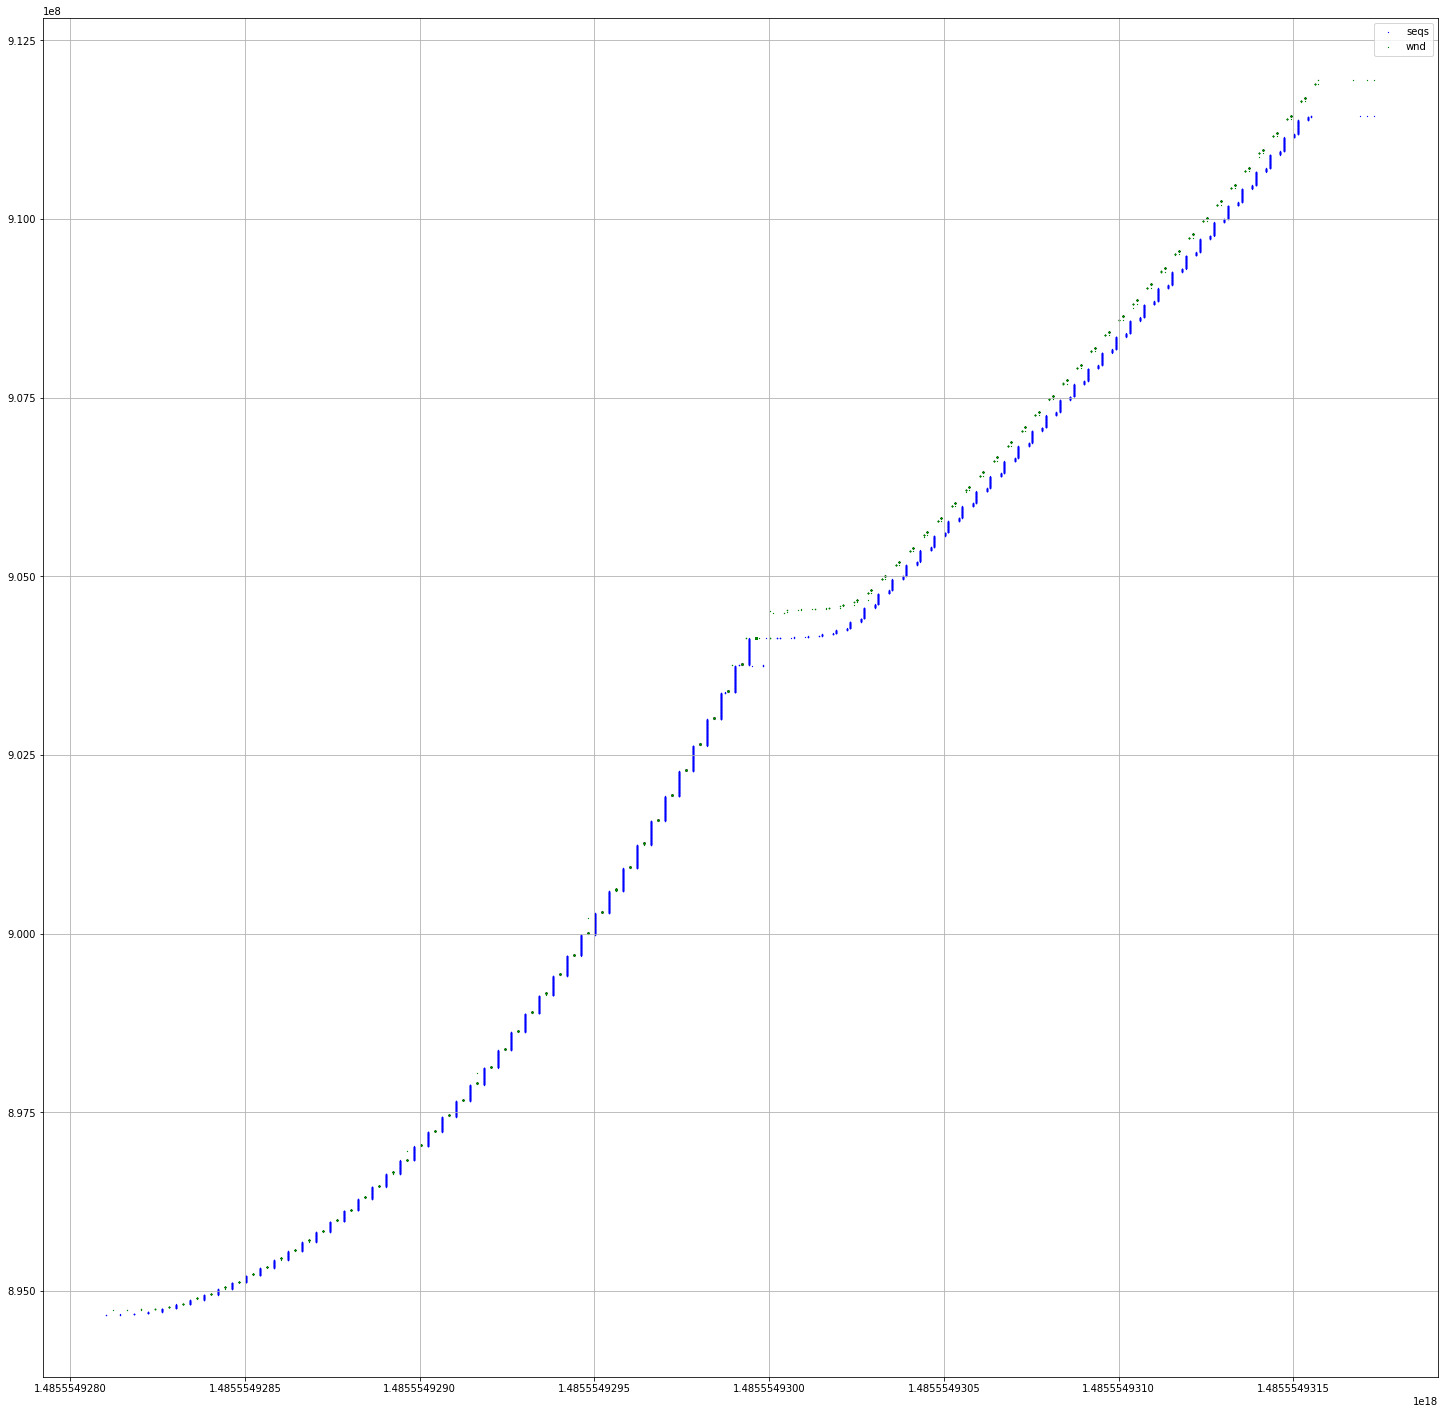

In [49]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
seq_range = slice(0,len(times_seqs))
acks_range = slice(0,len(times_seqs))
wnd_w_acks = [sum(x) for x in zip(acks, wnd)]
ax.scatter(times_seqs[seq_range], seqs[seq_range], s = 0.1, marker="x", label = "seqs")
#ax.scatter(times_acks[acks_range], acks[acks_range], s = 0.1, marker="x", label = "acks")
ax.scatter(times_acks[acks_range], wnd_w_acks[acks_range], s = 0.1, marker="x", label = "wnd")
ax.legend(scatterpoints=1)
ax.grid(True)
plt.ticklabel_format(useOffset=False)

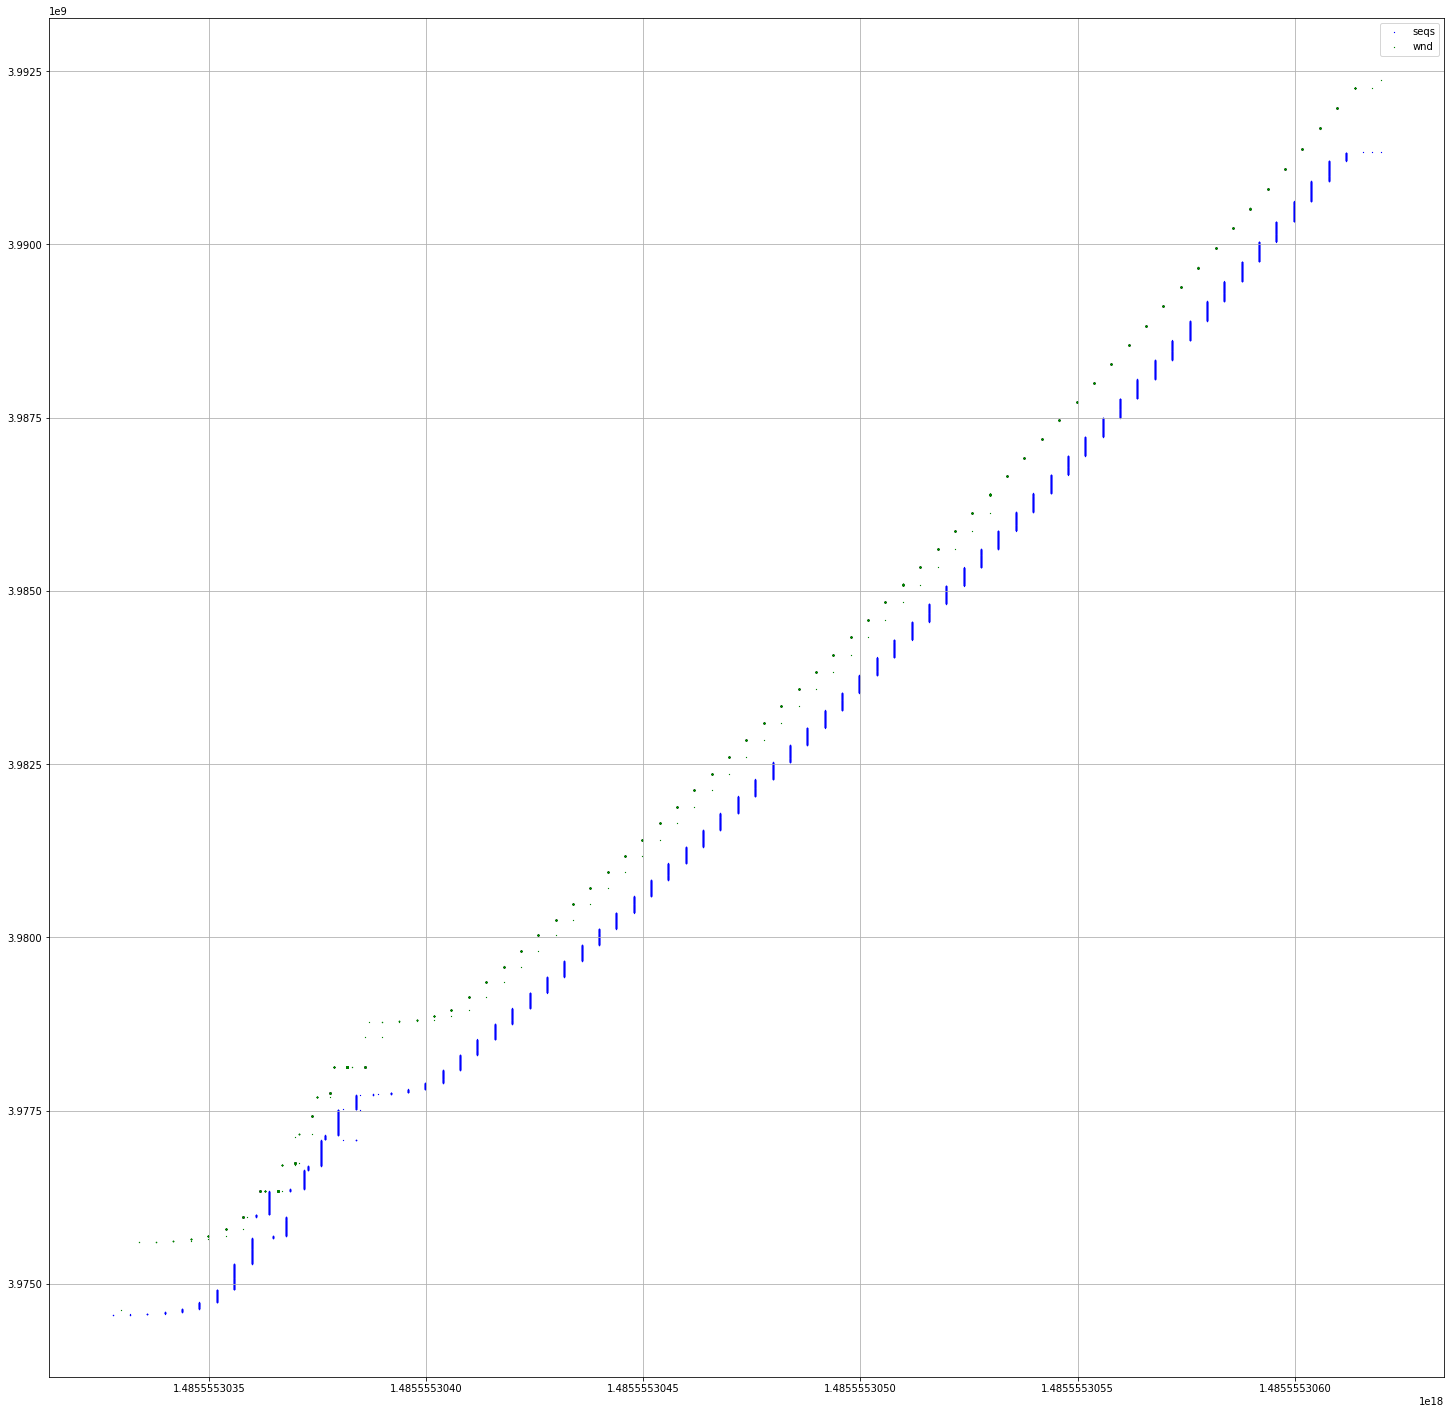

In [51]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
seq_range = slice(0,len(times_seqs_s))
acks_range = slice(0,len(times_seqs_s))
wnd_w_acks = [sum(x) for x in zip(acks_s, wnd_s)]
ax.scatter(times_seqs_s[seq_range], seqs_s[seq_range], s = 0.1, marker="x", label = "seqs")
#ax.scatter(times_acks[acks_range], acks[acks_range], s = 0.1, marker="x", label = "acks")
ax.scatter(times_acks_s[acks_range], wnd_w_acks[acks_range], s = 0.1, marker="x", label = "wnd")
ax.legend(scatterpoints=1)
ax.grid(True)
plt.ticklabel_format(useOffset=False)

## 10ms RTT

In [52]:
ret_rcv = process_segments("combined_5_1.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd = process_segments("combined_5_1.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks, acks, wnd = (ret_rcv["Time"], ret_rcv["Ack"], ret_rcv["wnd"])
times_seqs, seqs = (ret_snd["Time"], ret_snd["Seq"])
ret_rcv_s = process_segments("combined_5_1_-s.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd_s = process_segments("combined_5_1_-s.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks_s, acks_s, wnd_s = (ret_rcv_s["Time"], ret_rcv_s["Ack"], ret_rcv_s["wnd"])
times_seqs_s, seqs_s = (ret_snd_s["Time"], ret_snd_s["Seq"])

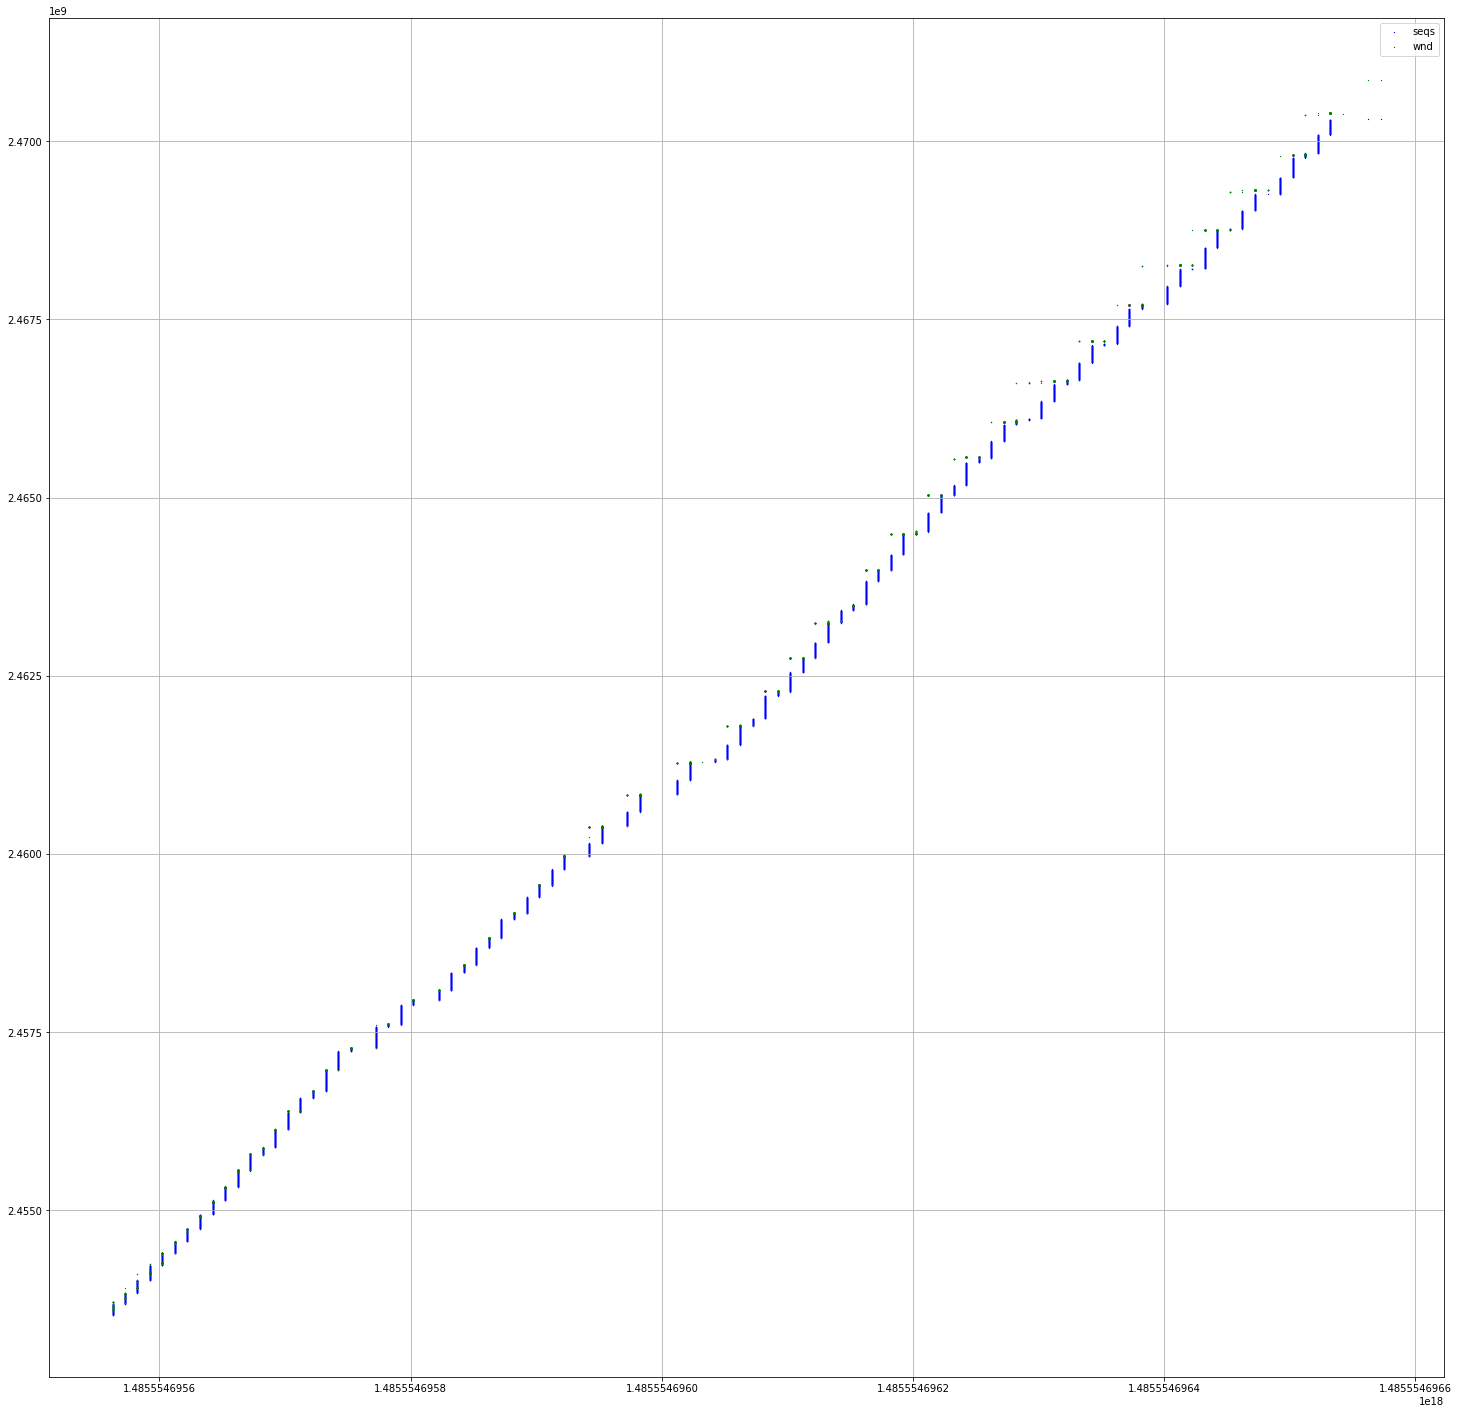

In [53]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
seq_range = slice(0,len(times_seqs))
acks_range = slice(0,len(times_seqs))
wnd_w_acks = [sum(x) for x in zip(acks, wnd)]
ax.scatter(times_seqs[seq_range], seqs[seq_range], s = 0.1, marker="x", label = "seqs")
#ax.scatter(times_acks[acks_range], acks[acks_range], s = 0.1, marker="x", label = "acks")
ax.scatter(times_acks[acks_range], wnd_w_acks[acks_range], s = 0.1, marker="x", label = "wnd")
ax.legend(scatterpoints=1)
ax.grid(True)
plt.ticklabel_format(useOffset=False)

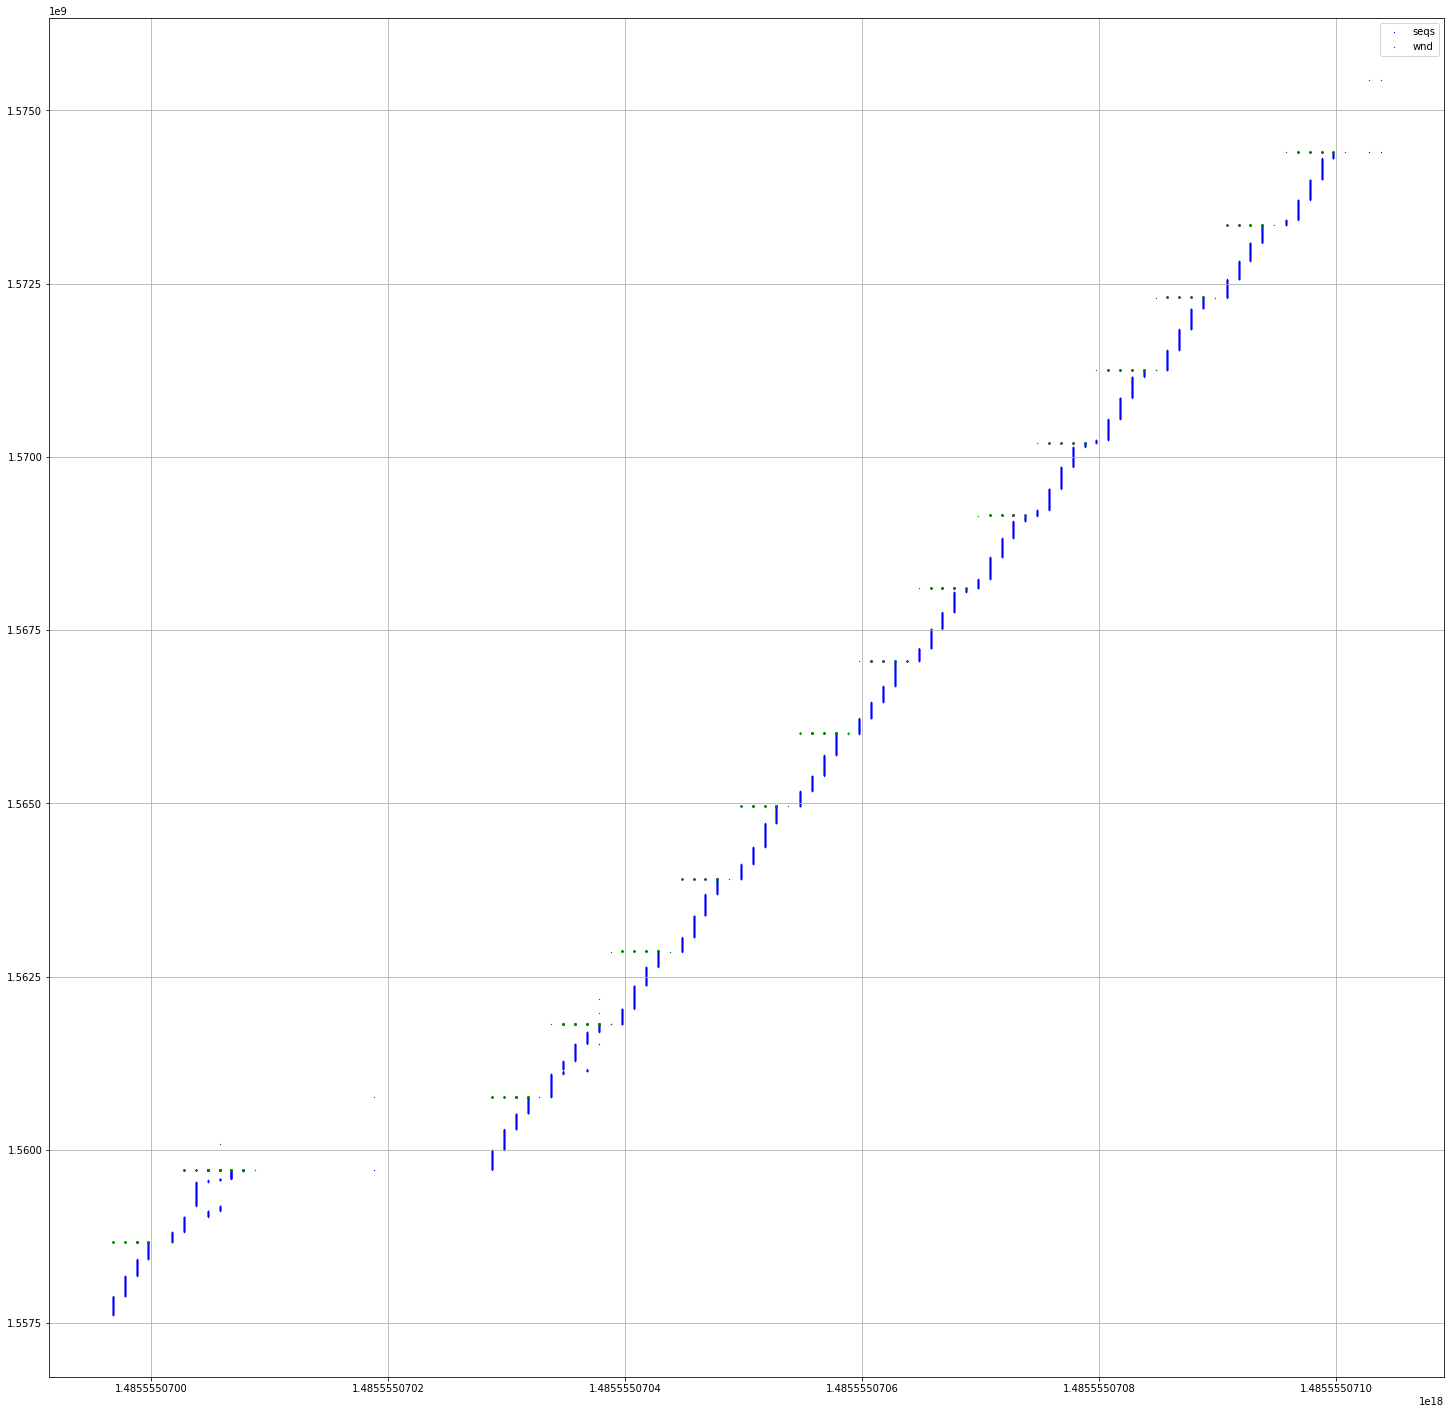

In [54]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
seq_range = slice(0,len(times_seqs_s))
acks_range = slice(0,len(times_seqs_s))
wnd_w_acks = [sum(x) for x in zip(acks_s, wnd_s)]
ax.scatter(times_seqs_s[seq_range], seqs_s[seq_range], s = 0.1, marker="x", label = "seqs")
#ax.scatter(times_acks[acks_range], acks[acks_range], s = 0.1, marker="x", label = "acks")
ax.scatter(times_acks_s[acks_range], wnd_w_acks[acks_range], s = 0.1, marker="x", label = "wnd")
ax.legend(scatterpoints=1)
ax.grid(True)
plt.ticklabel_format(useOffset=False)

## Probe Effect

	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
Running: ipc/ipc-static  -i tcp -b 1048576 -t 16777216 2thread
Discarded
Run: 1
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 2
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 3
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 4
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 5
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 6
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 7
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 8
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 9
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 10
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 11
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 12
net.inet.tcp.hostcache.purgenow: 0 -> 0
Aggregating
			1048576 bytes 16777216 bytes: 20861.02 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
Running: ipc/ipc-static  -i tcp -b 1048576 -t 16777216 2thread
Discarded
Run: 1
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 

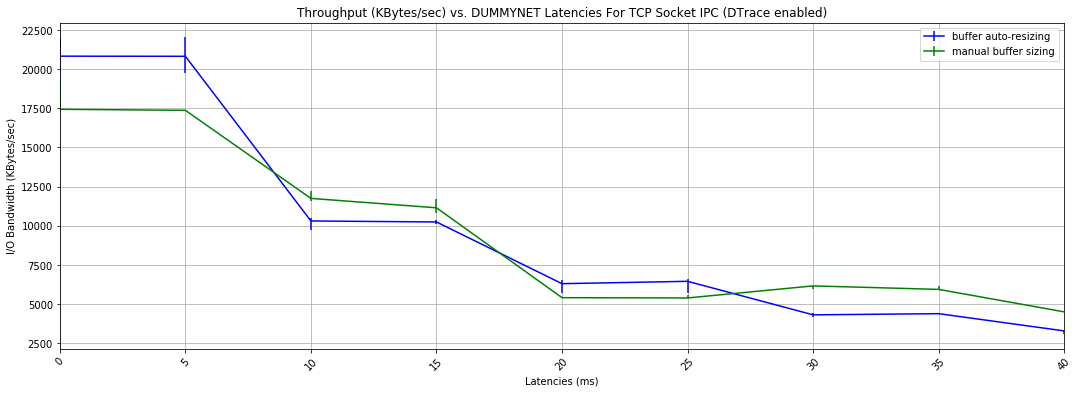

In [14]:
MODE="2thread"
IPC="tcp"
RUNS=12
EXE = "ipc/ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
TOT_SIZES=[BUFFER_SIZES[-1]]
BUF_SIZE=[1048576]
LATENCIES=range(0, 45, 5) # 0-40ms

ret = []
FLAGS=""
for lat in LATENCIES:
    # Run benchmark with DTrace
    !ipfw pipe config 1 delay {str(lat)}
    !ipfw pipe config 2 delay {str(lat)}
    ret.append(benchmark(FLAGS, 12, EXE, MODE, IPC, BUF_SIZE, TOT_SIZES, purge_cache = True,
                            dtrace_info = {'agg_fn':dummy_agg, 'script':D_rcv_tcp_in})[0])
pd.to_pickle(ret, "pkls/latency_vs_bandwidth_purge_probe_effect_segment.pkl")

#ret = pd.read_pickle("pkls/latency_vs_bandwidth_purge_probe_effect_segment.pkl")
p = graph(LATENCIES, flatten([item['speeds'] for item in ret]), RUNS,
         xlabel='Latencies (ms)', ylabel='I/O Bandwidth (KBytes/sec)',
          label="buffer auto-resizing", title = "Throughput (KBytes/sec) vs. DUMMYNET Latencies For TCP Socket IPC (DTrace enabled)")

ret = []
FLAGS="-s"
for lat in LATENCIES:
    # Run benchmark with DTrace
    !ipfw pipe config 1 delay {str(lat)}
    !ipfw pipe config 2 delay {str(lat)}
    ret.append(benchmark(FLAGS, 12, EXE, MODE, IPC, BUF_SIZE, TOT_SIZES, purge_cache = True,
                           dtrace_info = {'agg_fn':dummy_agg, 'script':D_rcv_tcp_in})[0])
pd.to_pickle(ret, "pkls/latency_vs_bandwidth_match_purge_probe_effect_segment.pkl")

saveas = "latency_vs_bw_all"
#ret = pd.read_pickle("pkls/latency_vs_bandwidth_match_purge_probe_effect_segment.pkl")
graph(LATENCIES, flatten([item['speeds'] for item in ret]), RUNS,
      axis = p, label="manual buffer sizing", save = True, save_name = saveas)

# Statistical Analysis

* do null hypothesis test on mean for thread models for pipe vs local; do null hypothesis test on local with and without matching buffers
* median test using scipy->run 10 and 20 runs of benchmark for hypothesis tests->plot p-value as buffer size increases
* test for statistical difference in matching vs. non-matching socketpairs
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html
* https://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/meditest.htm
* https://en.wikipedia.org/wiki/Median_test
* https://www.cl.cam.ac.uk/teaching/1819/L41/notes/2018-2019-l41-lab-1-io-notes.pdf

# Notes

* https://www.cl.cam.ac.uk/teaching/1819/L41/2018-2019-l41-lecturelet4-lab-tcp-p1-handout.pdf
* RFC 793: https://tools.ietf.org/html/rfc793
* RFC 893: https://tools.ietf.org/html/rfc893
* dtrace -n 'fbt::tcp_do_segment:entry/ntohs(args[3]->t_inpcb->inp_inc.inc_ie.ie_lport) == 10141 || ntohs(args[3]->t_inpcb->inp_inc.inc_ie.ie_fport) == 10141/ { trace((unsigned int)args[1]->th_seq); trace((unsigned int)args[1]->th_ack); trace(tcp_state_string[args[3]->t_state]);}'
  * state-syn-sent
  * state-syn-received
  * state-established
  * state-fin-wait-1
  * state-fin-wait-2
  * state-last-ack
* For state transitions:
  * dtrace -n 'fbt::tcp_state_change:entry/ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport) == 10141 || ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport) == 10141/ {   trace(ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport));  trace(ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport));  trace(tcp_state_string[args[0]->t_state]);  trace(tcp_state_string[args[1]]); }'
* Sequence numbers have a gap of 44bytes between each other

## IPFW and DUMMYNET
* Should be:
  * 2thread
  * ipc-static
  * without -s
  * tcp mode
* TODO: add below snippets to benchmark shell script

* Lab:
  * Plot:
    * TCP state-transition diagram for two directions of a single TCP connection
    * nodes: states
    * edges: transitions
    * indicate client vs server for diverging transitions
    * for each indicate TCP header flags of received packet or syscall (or other event e.g. timer) that triggers transition
  * Compare graphs to TCP stat diagram in RFC 793
  * Use DUMMYNET to explore effects of simulated latency at 5ms intervals between 0ms and 40ms. Record changes to state-machine transisionts as latency changes
  * For above use -B -q flags (whole-program analysis)